The `keras` API provides an excellent wrapper around various Deep Learning libraries, allowing both ease of use/uniform code while still plugging into expressive backends.

Generally speaking, `keras` allows two interfaces to the underlying libraries it abstracts:

- Sequential, object-oriented
- Functional, as the name implies

To explain the difference, we'll make the same Network in both fashions. This will consist of:

- Creating the structure:
    - Dense, 32-node layer, that takes input shape 784
    - Another 2 Dense 32 layers
    - A final Dense 10 layer with a `softmax()` activation function
- Compiling the model with the `categorical_crossentropy` loss function and `adam` optimizer
- Printing a summary of our model

### Sequential API

In [1]:
from keras import layers
from keras import models

Using TensorFlow backend.


In [2]:
model = models.Sequential()

model.add(layers.Dense(32, input_shape=(784,)))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(10, activation='softmax'))

In [3]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 27,562
Trainable params: 27,562
Non-trainable params: 0
_________________________________________________________________


### Functional API

Very similar to the Sequential model, but we have to manually specify how layers flow into one another, via the trailing `(past_tensor)` syntax.

Additionally, we specify which tensors are the first and last in the model-- in this case they're the `layers.Input()` and `layers.Dense(10)` objects.

In [5]:
input_tensor = layers.Input(shape=(784,))

x1 = layers.Dense(32, activation='relu')(input_tensor)
x2 = layers.Dense(32, activation='relu')(x1)
output_tensor = layers.Dense(10, activation='softmax')(x2)

model = models.Model(inputs=input_tensor, outputs=output_tensor)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


## Movie Example

Per chapter 3 in Francois Chollet's Deep Learning with Python book, let's take a quick look at how to build a simple model using data that comes native with `keras`.

The `imdb` dataset is essentially 50k movie reviews, where `X` is a label-encoded representation of the words in a review, and `y` is a positive or negative score.

In [7]:
from keras.datasets import imdb

`num_words=10000` limits the number of words that we use to represent a review.

In [8]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Insightful stuff in this review

In [9]:
train_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

They seemed to like the movie

In [10]:
train_labels[0]

1

`keras.datasets.imdb` comes pre-loaded with a dictionary to help decode the `X` representations of reviews. With some clever `dict` magic, we can reconstruct what the original review read, more or less.

Note: The `0, 1, 2` indexes are used for "padding", "start of sequence" and "unknown", hence the `-3` in the `get()` function

In [11]:
word_index = imdb.get_word_index()
reverse_word_index = {idx: word for word, idx in word_index.items()}

decoded_review = ' '.join(reverse_word_index.get(idx - 3, '?') for idx in train_data[0])
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

Taking this one step further, though, we want to be able to translate our `1 x numWords` observations into hot-encoded *matricies* that are consumable by a Neural Network.

In [12]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [13]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [14]:
x_train.shape

(25000, 10000)

Much better

In [15]:
x_train[0]

array([ 0.,  1.,  1., ...,  0.,  0.,  0.])

The transformation on `y` is trivial. Just `list` to `np.array`.

In [16]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Reusing the `Sequential()` architecture as above.

In [17]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Note that we specify that we want the `accuracy` metric (more on this in a sec)

In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

We split our `x_train` and `y_train` again in order to generate some cross-validation data

In [19]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

By passing `x_val, y_val`, we can do some cross-validation on the fly.

**Note** that we assign the output of `model.fit()` to `history`

In [20]:
history = model.fit(partial_x_train, partial_y_train,
                   epochs=20, batch_size=512,
                   validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 176us/step - loss: 0.5184 - acc: 0.7785 - val_loss: 0.3404 - val_acc: 0.8718
Epoch 2/20
15000/15000 [==============================] - 2s 143us/step - loss: 0.2426 - acc: 0.9129 - val_loss: 0.2770 - val_acc: 0.8911
Epoch 3/20
15000/15000 [==============================] - 2s 146us/step - loss: 0.1533 - acc: 0.9473 - val_loss: 0.2972 - val_acc: 0.8829
Epoch 4/20
15000/15000 [==============================] - 2s 147us/step - loss: 0.1063 - acc: 0.9669 - val_loss: 0.3246 - val_acc: 0.8811
Epoch 5/20
15000/15000 [==============================] - 2s 149us/step - loss: 0.0734 - acc: 0.9817 - val_loss: 0.3586 - val_acc: 0.8767
Epoch 6/20
15000/15000 [==============================] - 2s 145us/step - loss: 0.0489 - acc: 0.9905 - val_loss: 0.4016 - val_acc: 0.8783
Epoch 7/20
15000/15000 [==============================] - 2s 147us/step - loss: 0.0319 - acc: 0.9949 - val_loss: 0.4464 - 

We can now access the `history` values of `history` (lol)

In [21]:
history_dict = history.history

In [22]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

This allows us to look at performance over training time

In [23]:
%pylab inline

epochs = range(len(history_dict['loss']))

Populating the interactive namespace from numpy and matplotlib


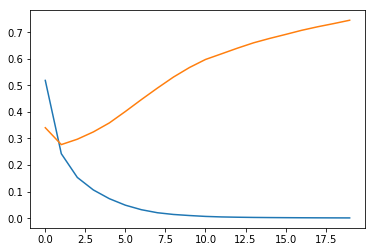

In [24]:
plt.plot(epochs, history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])